In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
import seaborn as sns
import os
import ipywidgets as widgets
import pandas as pd

from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
# Import Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\RCPL\.cache\kagglehub\datasets\abdallahalidev\plantvillage-dataset\versions\3


In [3]:
# Move data dir to the color folder
data_dir = pathlib.Path(path).with_suffix('')
data_dir_color = data_dir / 'plantvillage dataset' / 'color'

print("Color dir: ", data_dir_color)

Color dir:  C:\Users\RCPL\.cache\kagglehub\datasets\abdallahalidev\plantvillage-dataset\versions\3\plantvillage dataset\color


In [4]:
# Create directories to hold healthy and diseased
healthy_dir = data_dir_color / 'healthy'
healthy_dir.mkdir(exist_ok=True)

diseased_dir = data_dir_color / 'diseased'
diseased_dir.mkdir(exist_ok=True)

In [5]:
# If a directory is healthy it's moved to the healthy directory
for dir in data_dir_color.iterdir():
    if '_healthy' in dir.name:
        dir.rename(healthy_dir / dir.name)

In [6]:
# If a directory is diseased it's moved to the diseased directory
for dir in data_dir_color.iterdir():
    if '__' in dir.name:
        dir.rename(diseased_dir / dir.name)

In [7]:
# Basic CNN classification model referenced from https://www.tensorflow.org/tutorials/images/classification
# Keras image parameters
batch_size = 32
img_height = 224
img_width = 224

In [8]:
# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_color,
    validation_split=0.2,
    subset="training",
    seed=21,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 54305 files belonging to 2 classes.
Using 43444 files for training.


In [9]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_color,
    validation_split=0.2,
    subset="validation",
    seed=21,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 54305 files belonging to 2 classes.
Using 10861 files for validation.


In [10]:
# Store the class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['diseased', 'healthy']


In [11]:
# Normalize the data
normalization_layer = layers.Rescaling(1. / 255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9173042


In [12]:
# Instantiate shuffling and prefetching of data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Data augmentation to help overfitting
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

C:\Users\RCPL\miniconda3\envs\crop-disease-detection\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Load model
new_model = tf.keras.models.load_model("models/crop_disease_detection_model.keras")

new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,339,496 (73.77 MB)

 Trainable params: 6,446,498 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,892,998 (49.18 MB)

In [15]:
# Evaluate the restored model
loss, acc = new_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

340/340 - 15s - 45ms/step - accuracy: 0.8797 - loss: 0.2837
Restored model, accuracy: 87.97%


In [16]:
# Model training log code referenced from https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python?rq=3
# Retrieve model training history
log_data = pd.read_csv('training.log', sep=',', engine='python')

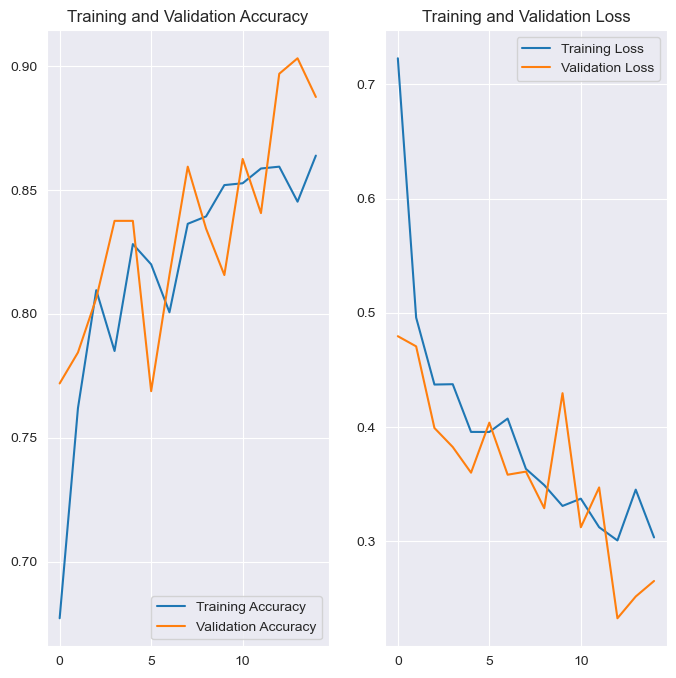

In [17]:
# Create a diagram of the training and validation accuracy and loss
acc = log_data['accuracy']
val_acc = log_data['val_accuracy']

loss = log_data['loss']
val_loss = log_data['val_loss']

epochs_range = range(len(log_data))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Classes extracted code referenced from https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri
# Create arrays to store predicted and true labels
y_pred = []
y_true = []

# Iterate over the validation dataset
for images, labels in val_ds:
    y_true.append(labels)
    # Use model to predict labels
    predictions = new_model.predict(images)
    y_pred.append(np.argmax(predictions, axis=-1))

# Convert the labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

In [19]:
# Confusion Matrix referenced from https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
# Create a confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)

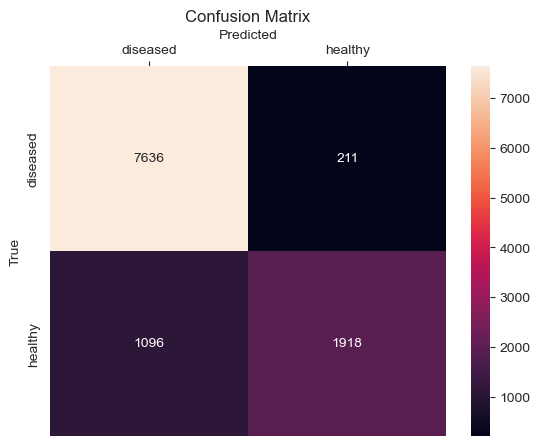

In [20]:
# Plot the confusion matrix and use seaborn to create a heatmap
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
# Move the x-axis title and labels to the top
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

plt.show()

In [21]:
# Print a classification report
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      7847
           1       0.90      0.64      0.75      3014

    accuracy                           0.88     10861
   macro avg       0.89      0.80      0.83     10861
weighted avg       0.88      0.88      0.87     10861



In [22]:
# Create arrays to hold the disease names and number of images per disease
diseases = []
num_images = []

for child in diseased_dir.iterdir():
    if child.is_dir():
        diseases.append(child.name)
        num_images.append(len(os.listdir(child)))

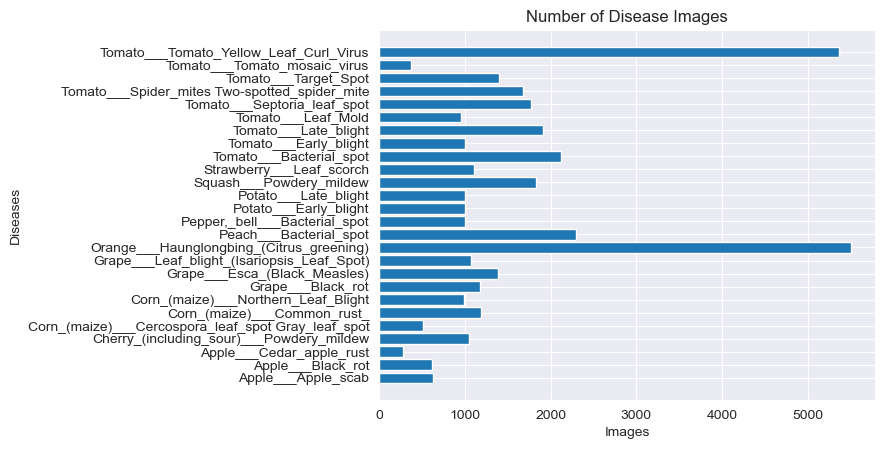

In [23]:
# Bar chart code referenced from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
# Create a horizontal bar chart for the number of disease images
plt.barh(diseases, num_images)
plt.title('Number of Disease Images')
plt.ylabel('Diseases')
plt.xlabel('Images')
plt.show()

In [24]:
# Widget code referenced from https://ashejim.github.io/C964/task2_c/example_sup_class/sup_class_ex-ui.html
# UI - Create a widget where the user can input an image URL and receive the model's prediction
url_widget = widgets.Text(description='Image URL')

button_predict = widgets.Button(description='Predict')
button_output = widgets.Label(value='Enter an image URL and press the \"Predict\" button.')

def on_click_predict(b):
    test_imate_path = tf.keras.utils.get_file('test_img', origin=url_widget.value)
    img = tf.keras.utils.load_img(test_imate_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = new_model.predict(img_array)
    score = tf.nn.softmax(prediction[0])

    button_output.value = 'The image is predicted to be {} with a {:.2f} percent certainty.'.format(class_names[np.argmax(score)], 100 * np.max(score))

button_predict.on_click(on_click_predict)

vbox = widgets.VBox(children=[url_widget, button_predict, button_output])
display(vbox)